c:\Users\Dzu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


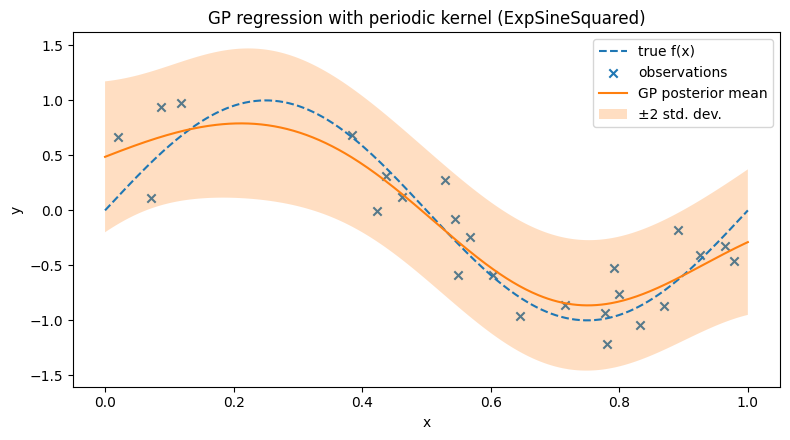

Learned kernel: 1.08**2 * ExpSineSquared(length_scale=0.156, periodicity=10) + WhiteKernel(noise_level=0.205)
Log Marginal Likelihood: -22.481019683634894


In [16]:
# Generative demonstration: fit a Gaussian Process with a periodic kernel to data y = sin(2πx) + 0.3·N(0,1)
# This cell:
# 1) generates data,
# 2) fits a GP with a periodic kernel (ExpSineSquared) + WhiteKernel,
# 3) predicts on a dense grid,
# 4) plots posterior mean and ±2 standard error bands,
# 5) prints learned kernel hyperparameters and log-marginal-likelihood.
#
# Notes:
# - Uses sklearn GaussianProcessRegressor which will optimize kernel hyperparameters by maximizing the
#   log marginal likelihood (type-II ML).
# - Do not set matplotlib colors explicitly (per tool instructions).
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, ExpSineSquared, RBF, WhiteKernel

np.random.seed(0)

# Generate data
N = 25
X = np.random.rand(N, 1)  # in [0,1]
true_f = lambda x: np.sin(2 * np.pi * x)
noise_sd = 0.3
y = true_f(X).ravel() + noise_sd * np.random.randn(N)

# Define kernel: amplitude * periodic + small RBF + white noise
# periodic kernel (ExpSineSquared) has a 'periodicity' parameter; set initial 1.0 (we expect period=1)
kernel = (ConstantKernel(1.0, (1e-3, 1e3)) * ExpSineSquared(length_scale=0.5, periodicity=1.0,
                                                            length_scale_bounds=(1e-2, 1e2),
                                                            periodicity_bounds=(1e-2, 10.0))
        #  + RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e2))
         + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0)))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)
gp.fit(X, y)

# Predict on dense grid
Xgrid = np.linspace(0, 1, 400).reshape(-1, 1)
y_mean, y_std = gp.predict(Xgrid, return_std=True)

# Plot
plt.figure(figsize=(8, 4.5))
plt.plot(Xgrid, true_f(Xgrid), linestyle='--', label='true f(x)')  # dashed true function
plt.scatter(X, y, marker='x', label='observations')
plt.plot(Xgrid, y_mean, label='GP posterior mean')
plt.fill_between(Xgrid.ravel(), (y_mean - 2*y_std).ravel(), (y_mean + 2*y_std).ravel(), alpha=0.25, label='±2 std. dev.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP regression with periodic kernel (ExpSineSquared)')
plt.legend()
plt.tight_layout()
plt.show()

# Print learned kernel and log-marginal-likelihood
print("Learned kernel:", gp.kernel_)
print("Log Marginal Likelihood:", gp.log_marginal_likelihood(gp.kernel_.theta))


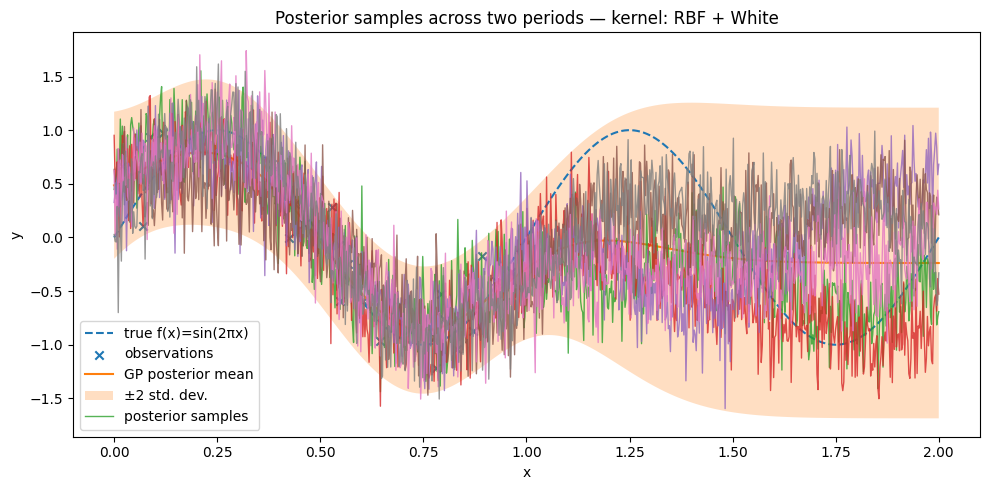

Kernel: RBF + White
  Learned kernel: 1.08**2 * RBF(length_scale=0.248) + WhiteKernel(noise_level=0.205)
  Log Marginal Likelihood: -22.475683007319525
------------------------------------------------------------


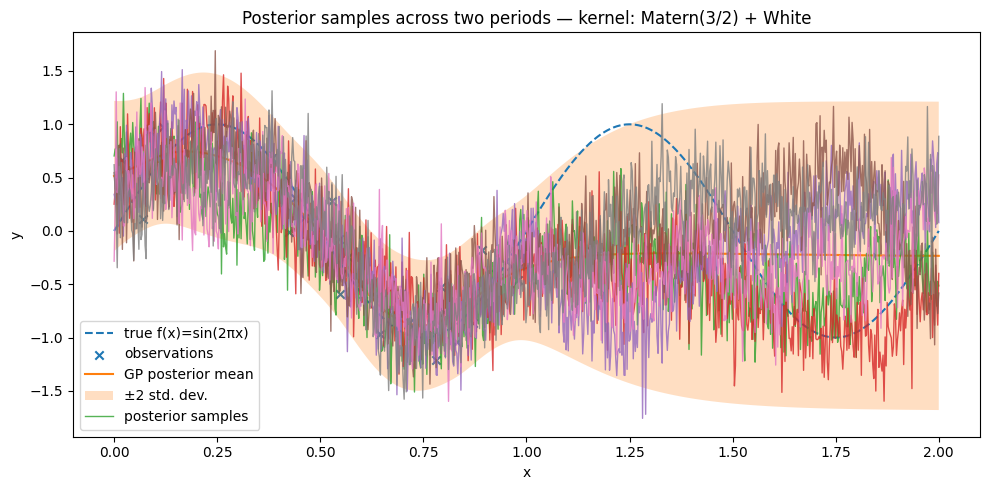

Kernel: Matern(3/2) + White
  Learned kernel: 1.08**2 * Matern(length_scale=0.349, nu=1.5) + WhiteKernel(noise_level=0.206)
  Log Marginal Likelihood: -23.10912537283767
------------------------------------------------------------


c:\Users\Dzu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


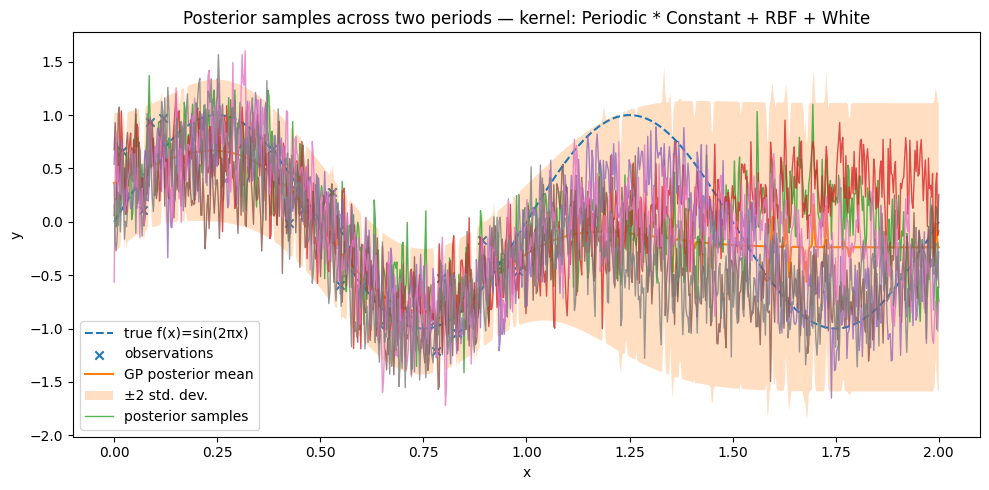

Kernel: Periodic * Constant + RBF + White
  Learned kernel: 0.447**2 * ExpSineSquared(length_scale=0.0137, periodicity=0.805) + RBF(length_scale=0.239) + WhiteKernel(noise_level=1e-06)
  Log Marginal Likelihood: -21.155512474606425
------------------------------------------------------------


In [ ]:
# Draw posterior samples across two periods [0,2] for the three kernels and plot them.
# For each kernel: fit GP on data in [0,1], predict on grid [0,2], plot posterior mean, ±2 std, and overlay 6 posterior samples.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel, ExpSineSquared

np.random.seed(0)
N = 25
X = np.random.rand(N, 1)  # training inputs in [0,1]
true_f = lambda x: np.sin(2 * np.pi * x)
noise_sd = 0.3
y = true_f(X).ravel() + noise_sd * np.random.randn(N)

# Prediction grid spans two periods
Xgrid = np.linspace(0, 2, 800).reshape(-1, 1)
true_vals = np.sin(2 * np.pi * Xgrid)

kernels = {
    "RBF + White": 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0)),
    "Matern(3/2) + White": 1.0 * Matern(length_scale=0.2, nu=1.5, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0)),
    "Periodic * Constant + RBF + White": ConstantKernel(1.0, (1e-3, 1e3)) * ExpSineSquared(length_scale=0.5, periodicity=1.0,
                                                                                              length_scale_bounds=(1e-2, 1e2),
                                                                                              periodicity_bounds=(0.8, 1.2)) \
                                             + RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e2)) \
                                             + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0))
}

n_samples = 6  # number of posterior sample functions to draw

for name, kernel in kernels.items():
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)
    gp.fit(X, y)
    y_mean, y_std = gp.predict(Xgrid, return_std=True)
    samples = gp.sample_y(Xgrid, n_samples=n_samples, random_state=42)  # shape (n_points, n_samples)

    plt.figure(figsize=(10, 5))
    plt.plot(Xgrid, true_vals, linestyle='--', label='true f(x)=sin(2πx)')
    plt.scatter(X, y, marker='x', label='observations')
    plt.plot(Xgrid, y_mean, label='GP posterior mean')
    plt.fill_between(Xgrid.ravel(), (y_mean - 2*y_std).ravel(), (y_mean + 2*y_std).ravel(), alpha=0.25, label='±2 std. dev.')
    # Plot posterior samples
    for i in range(n_samples):
        plt.plot(Xgrid, samples[:, i], linewidth=1, alpha=0.8, label='posterior samples' if i==0 else None)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Posterior samples across two periods — kernel: {name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Kernel: {name}")
    print("  Learned kernel:", gp.kernel_)
    print("  Log Marginal Likelihood:", gp.log_marginal_likelihood(gp.kernel_.theta))
    print("-" * 60)


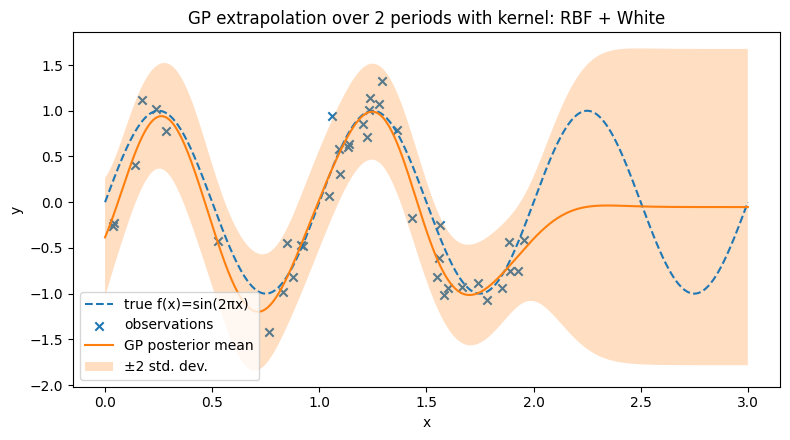

Kernel: RBF + White
  Learned kernel: 1.05**2 * RBF(length_scale=0.212) + WhiteKernel(noise_level=0.0971)
  Log Marginal Likelihood: -25.94009957701563
------------------------------------------------------------


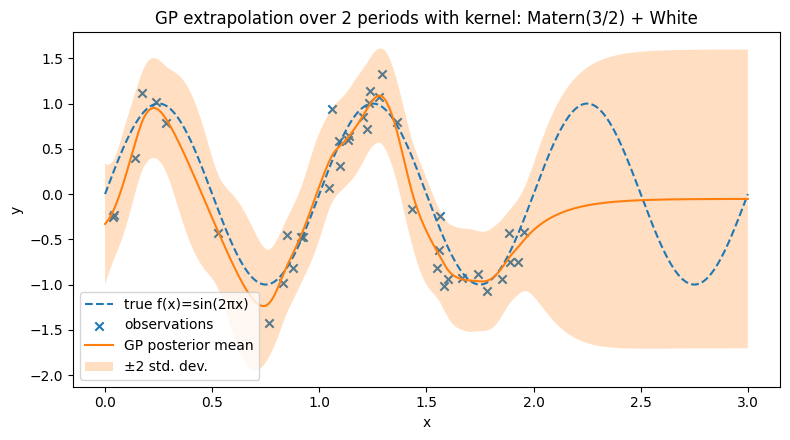

Kernel: Matern(3/2) + White
  Learned kernel: 1**2 * Matern(length_scale=0.252, nu=1.5) + WhiteKernel(noise_level=0.0854)
  Log Marginal Likelihood: -27.11641972068151
------------------------------------------------------------


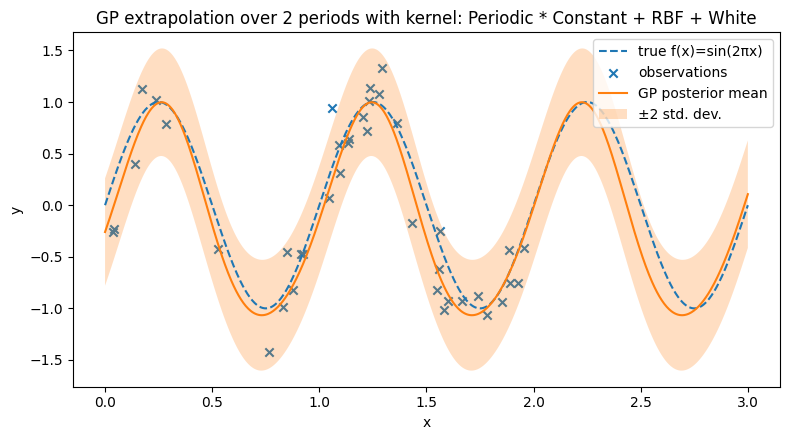

Kernel: Periodic * Constant + RBF + White
  Learned kernel: 1.84**2 * ExpSineSquared(length_scale=2.57, periodicity=0.981) + WhiteKernel(noise_level=0.099)
  Log Marginal Likelihood: -19.94813223216592
------------------------------------------------------------


In [17]:
# Compare the same three kernels but now over two full periods of the true sine wave (domain [0, 2]),
# to visualize extrapolation and periodic behavior differences.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel, ExpSineSquared

np.random.seed(0)
N = 40
X = np.random.rand(N, 1)  # in [0,1]
# ,ultilpy all elements by 2 to span [0,2]
X *= 2
true_f = lambda x: np.sin(2 * np.pi * x)
noise_sd = 0.3
y = true_f(X).ravel() + noise_sd * np.random.randn(N)

# Prediction grid now spans [0, 2]
Xgrid = np.linspace(0, 3, 800).reshape(-1, 1)

kernels = {
    "RBF + White": 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0)),
    "Matern(3/2) + White": 1.0 * Matern(length_scale=0.2, nu=1.5, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0)),
    "Periodic * Constant + RBF + White": ConstantKernel(1.0, (1e-3, 1e3)) * ExpSineSquared(length_scale=0.5, periodicity=1.0,
                                                                                              length_scale_bounds=(1e-2, 1e2),
                                                                                              periodicity_bounds=(0.8, 1.2)) \
                                            #  + RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e2)) \
                                             + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0))
}

for name, kernel in kernels.items():
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)
    gp.fit(X, y)
    y_mean, y_std = gp.predict(Xgrid, return_std=True)

    plt.figure(figsize=(8, 4.5))
    plt.plot(Xgrid, np.sin(2 * np.pi * Xgrid), linestyle='--', label='true f(x)=sin(2πx)')
    plt.scatter(X, y, marker='x', label='observations')
    plt.plot(Xgrid, y_mean, label='GP posterior mean')
    plt.fill_between(Xgrid.ravel(), (y_mean - 2*y_std).ravel(), (y_mean + 2*y_std).ravel(), alpha=0.25, label='±2 std. dev.')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'GP extrapolation over 2 periods with kernel: {name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    lml = gp.log_marginal_likelihood(gp.kernel_.theta)
    print(f"Kernel: {name}")
    print("  Learned kernel:", gp.kernel_)
    print("  Log Marginal Likelihood:", lml)
    print("-" * 60)


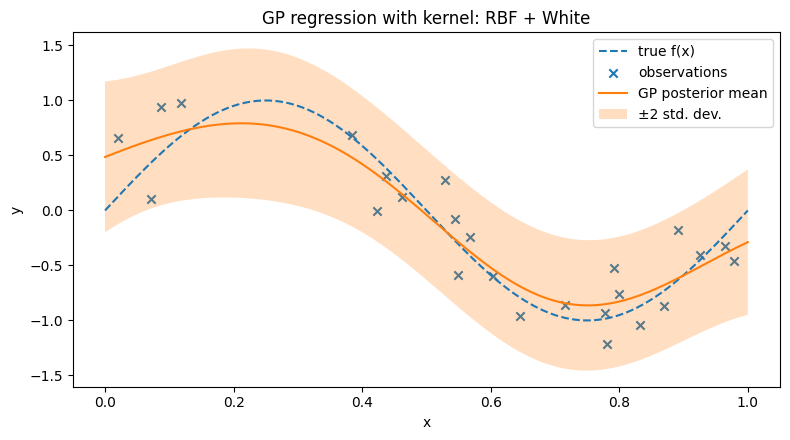

Kernel: RBF + White
  Learned kernel: 1.08**2 * RBF(length_scale=0.248) + WhiteKernel(noise_level=0.205)
  Log Marginal Likelihood: -22.475683007319525
------------------------------------------------------------


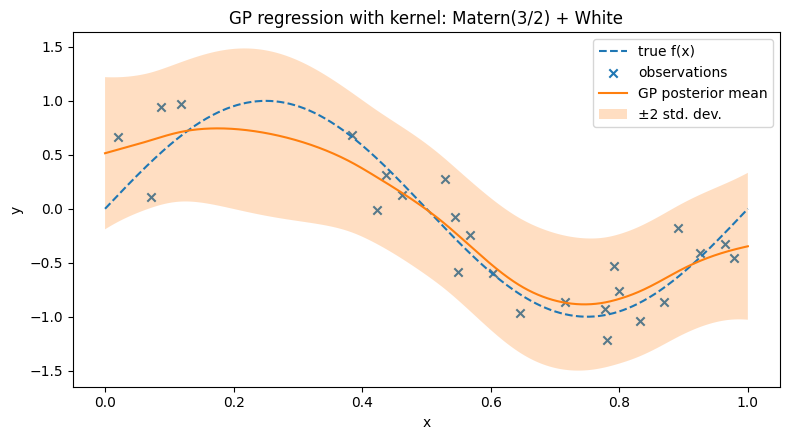

Kernel: Matern(3/2) + White
  Learned kernel: 1.08**2 * Matern(length_scale=0.349, nu=1.5) + WhiteKernel(noise_level=0.206)
  Log Marginal Likelihood: -23.10912537283767
------------------------------------------------------------


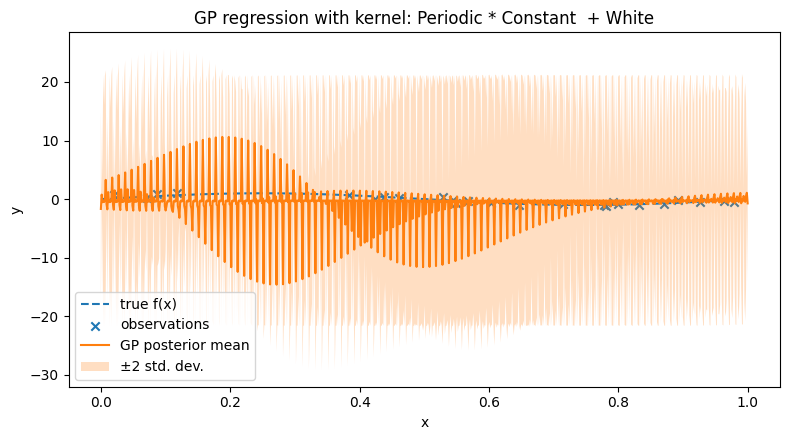

Kernel: Periodic * Constant  + White
  Learned kernel: 17.3**2 * ExpSineSquared(length_scale=0.0703, periodicity=0.01)
  Log Marginal Likelihood: -88.35566484929718
------------------------------------------------------------


In [ ]:
# Retry: Compare Gaussian Process fits with three different kernels.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel, ExpSineSquared

np.random.seed(0)
N = 25
X = np.random.rand(N, 1)
true_f = lambda x: np.sin(2 * np.pi * x)
noise_sd = 0.3
y = true_f(X).ravel() + noise_sd * np.random.randn(N)

Xgrid = np.linspace(0, 1, 800).reshape(-1, 1)

kernels = {
    "RBF + White": 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0)),
    "Matern(3/2) + White": 1.0 * Matern(length_scale=0.2, nu=1.5, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0)),
    "Periodic * Constant  + White": ConstantKernel(1.0, (1e-3, 1e3)) * ExpSineSquared(length_scale=0.5, periodicity=1,
                                                                                              length_scale_bounds=(1e-2, 1e2),
                                                                                              periodicity_bounds=(1e-2, 10.0)) \
                                            #  + RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e2)) \
                                             + WhiteKernel(noise_level=noise_sd**2, noise_level_bounds=(1e-6, 1.0))
}

for name, kernel in kernels.items():
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)
    gp.fit(X, y)
    y_mean, y_std = gp.predict(Xgrid, return_std=True)

    plt.figure(figsize=(8, 4.5))
    plt.plot(Xgrid, true_f(Xgrid), linestyle='--', label='true f(x)')
    plt.scatter(X, y, marker='x', label='observations')
    plt.plot(Xgrid, y_mean, label='GP posterior mean')
    plt.fill_between(Xgrid.ravel(), (y_mean - 2*y_std).ravel(), (y_mean + 2*y_std).ravel(), alpha=0.25, label='±2 std. dev.')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'GP regression with kernel: {name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    lml = gp.log_marginal_likelihood(gp.kernel_.theta)
    print(f"Kernel: {name}")
    print("  Learned kernel:", gp.kernel_)
    print("  Log Marginal Likelihood:", lml)
    print("-" * 60)
